In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('models')
from sim_cosmology import p, load_dataloader_and_pretrained_model
# adaptive-wavelets modules
sys.path.append('../../src')
sys.path.append('../../src/adaptive_wavelets')
from losses import get_loss_f
from train import Trainer, Validator
from transform2d import DWT
from utils import get_2dfilts
from viz import cshow, plot_reconstruct, plot_filts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)

In [23]:
# get image
torch.manual_seed(p.seed)
im = iter(test_loader).next()[0][0:64].to(device)

# wavelet transform 
wt = DWT(wave='db2', mode='symmetric', J=3, init_factor=1, noise_factor=0).to(device)

im_t = wt(im)
recon = wt.inverse(im_t)

print(torch.norm(im - recon)**2/im.size(0))

filt = get_2dfilts(wt)

tensor(4.6113e-13, device='cuda:0', grad_fn=<DivBackward0>)


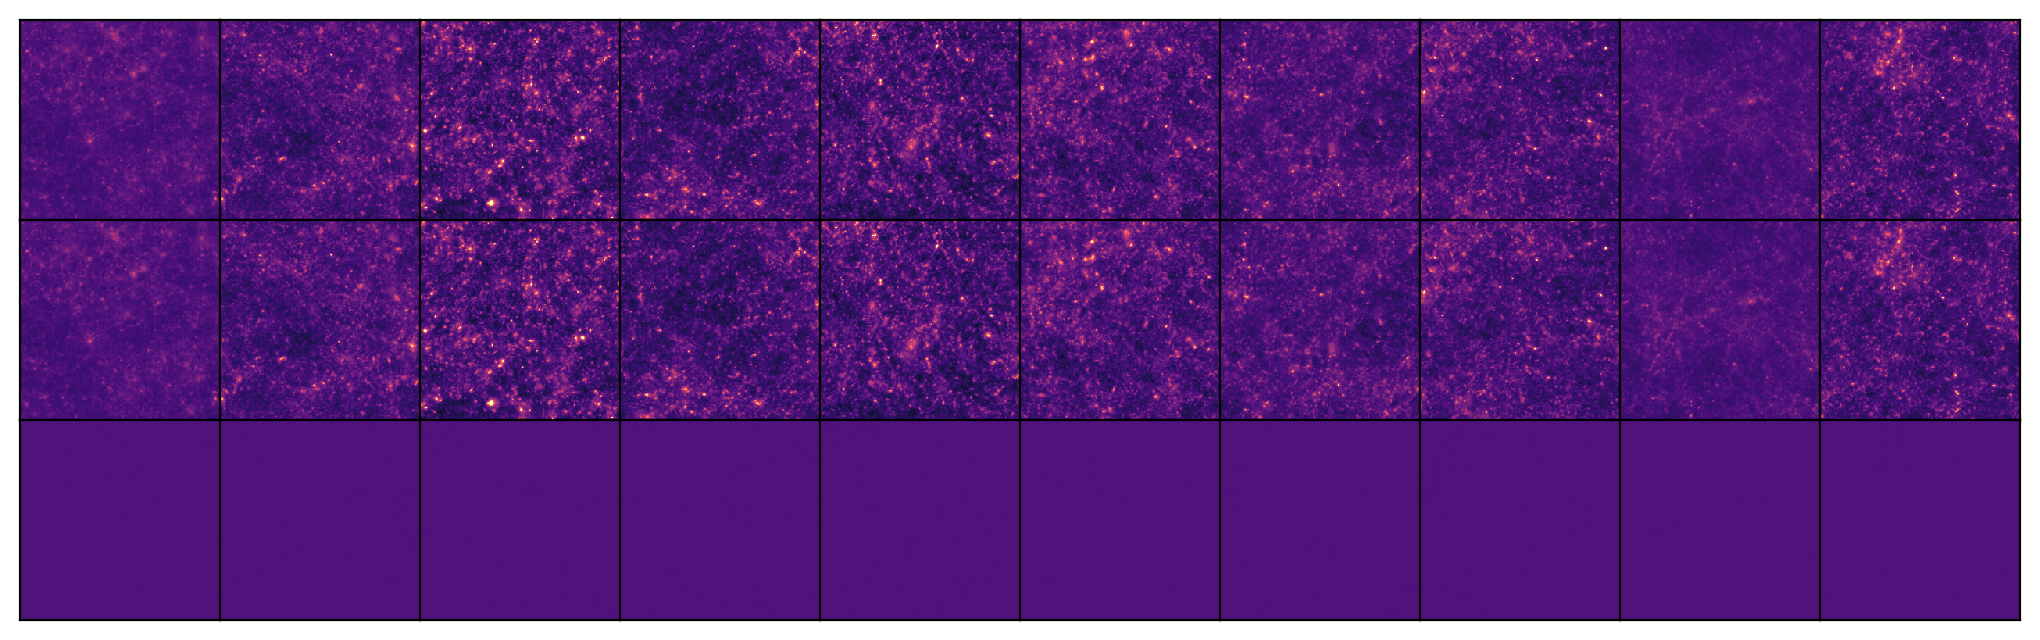

In [57]:
plot_reconstruct(im, recon)

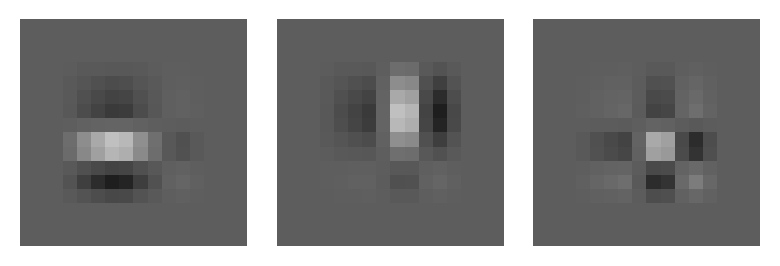

In [43]:
plot_filts(filt, figsize=(4,4), share_min_max=True)